In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import time

# in this notebook I'm investigating whether a 2 state process with a heavy-tailed sojourn time distribution in the static state and a light-tailed sojourn time distribution in the mobile state leads to 3-stage diffusion as I anticipate

In [451]:
# generate lots of random values for resting state 1 and moving state 2
n = int(1e5)
psi1 = (np.random.pareto(a = 1.1,size=n)+1)*1e-2
psi2 = np.random.exponential(0.1,size=n)

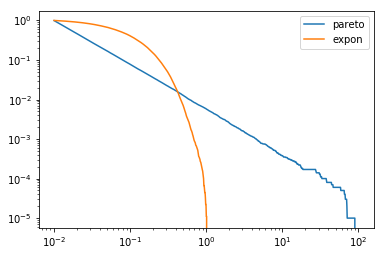

In [452]:
# visualize the distributions you made 
bins = np.geomspace(1e-2,1e2,1000)
hist,_ = np.histogram(psi1,bins)
hist1,_ = np.histogram(psi2,bins)
bins = bins[1:]
plt.loglog(bins,1-hist.cumsum()/hist.cumsum().max(),label='pareto')
plt.loglog(bins,1-hist1.cumsum()/hist1.cumsum().max(),label='expon')
plt.legend()

In [455]:
def walk(n=5000,a=1.9,b=0.5):
    """ two state random walk with pareto and expon distributions
    a is pareto alpha
    b is exponential rate
    returns states, times
    where times are the residence times in each state"""
    psi1 = (np.random.pareto(a,size=n//2)+1)*1e-2
    #psi1 = np.random.exponential(a,size=n//2)
    psi2 = np.random.exponential(b,size=n//2)
    weave = np.empty(n)
    weave[::2] = psi1
    weave[1::2] = psi2
    state1 = np.zeros_like(psi1)
    state2 = np.ones_like(psi2)
    state = np.empty_like(weave)
    state[::2]=state1
    state[1::2]=state2
    state = state.astype('int')
    return state,weave

def rolling_window(a, window=2):
    """crack [a,b,c,d] into [[a,b],[b,c],[c,d]]"""
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def displacement(walky,bins):
    """compute the position versus time from a random walk walky 
    provided its velocity in state 1 is u"""
    u=10.0
    twindows = rolling_window(bins)
    i = 0 
    x = 0 
    states,times=walky
    times_cs = times.cumsum()
    displacement = np.empty(twindows.shape[0])
    for tmin,tmax in twindows:
        mask = (times_cs>tmin)&(times_cs<tmax)&(states==1)
        motion_time = times[mask].sum() # cumulative time in motion between tmin and tmax
        dx = motion_time*u
        x = x+dx
        displacement[i]=x
        i+=1
    return displacement

def varcomputer(d_ens):
    out = []
    for d in d_ens.T:
        c = d[d!=0]
        if len(c)>0:
            out.append(np.var(c))
        else:
            out.append(None)
    return np.array(out)

In [458]:
t0 = time.time()
a=1.1 # pareto 
b=0.05 # exponential 
steps = int(1e6)
Nens = 100
Nbins = 100 
ensemble = [walk(steps,a=a,b=b) for _ in range(Nens)]
mintime = np.amin([w[1].cumsum() for w in ensemble])
maxtime = np.amax([w[1].cumsum() for w in ensemble])
bins = np.geomspace(mintime,maxtime,Nbins)
d_ens = [displacement(walky,bins) for walky in ensemble]
d_ens = np.array(d_ens)
#var_x = np.var(d_ens,0)
var_x = varcomputer(d_ens)
bins = (bins[1:]+bins[:-1])/2.0
print(round((time.time()-t0)/60,2))

0.73


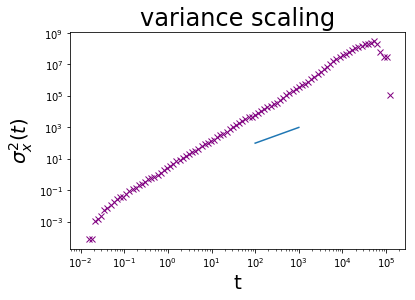

In [459]:
plt.loglog(bins,var_x,'x',color='purple')
plt.xlabel('t',fontsize=20)
plt.ylabel('$\sigma_x^2(t)$',fontsize=20)
plt.title('variance scaling',fontsize=24)
#plt.ylim(1e-4)
#plt.xlim(1e-2)
#tt = np.geomspace(1e-1,1,10)
#plt.loglog(tt,tt**2)
tt = np.geomspace(1e2,1e3,10)
plt.loglog(tt,tt)